In [1]:
%%time
# Imports
from utils import *

CPU times: total: 1.33 s
Wall time: 1.37 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
# user = []
# ts = []
ca = []
tweets = []
# mentions = []
coord = []
# country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        # user.append(line[0])
        # ts.append(line[1])
        ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        coord.append(line[5])
        # country.append(line[6])

CPU times: total: 27 s
Wall time: 27.7 s


# **03 - MAPPING**
### **QUESTION - 1**

In [3]:
%%time

# Use tweets and coordinates to create a mapping dataframe
mapping_df = pd.DataFrame(
    list(zip(tweets , ca , coord)) , columns = ['tweet_id' , 'ca' , 'coordinates']
)

# mapping_df = from_pandas(mapping_df , npartitions = 4)

# Removing unnecessary rows
mapping_df = mapping_df[
    (mapping_df['tweet_id']!="None")
    &(mapping_df['coordinates']!="None")
].drop_duplicates()

len(mapping_df)

CPU times: total: 9.17 s
Wall time: 9.17 s


701961

In [4]:
%%time

# Applying coordinates function (defined above)
mapping_df = to_coord(mapping_df , coord_cols=['coordinates'])

print(f'returned df has columns --> {mapping_df.columns}')
# Get the coordinates as arrays
x_coord = mapping_df['coordinates_long']
y_coord = mapping_df['coordinates_lat']

returned df has columns --> Index(['tweet_id', 'ca', 'coordinates_long', 'coordinates_lat'], dtype='object')
CPU times: total: 6.61 s
Wall time: 6.61 s


In [5]:
%%time

data = {}
pops = {}

# https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts
shape_file = os.path.join(os.getcwd() , 'world_map\\TM_WORLD_BORDERS_SIMPL-0.3.shp')

with fiona.open(shape_file) as layer:
    for feature in layer:
        country_code = feature['properties']['NAME']
        data[country_code] = shape(feature['geometry'])

patches = []
colours = []

for c in data:
    try:
        for p in data[c].geoms:
            lons , lats = np.array(p.exterior.coords.xy)
            patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))
    except AttributeError:
        lons , lats = np.array(data[c].exterior.coords.xy)
        patches.append(PolygonPatch(list(zip(lons , lats)) , closed = True))

CPU times: total: 359 ms
Wall time: 366 ms


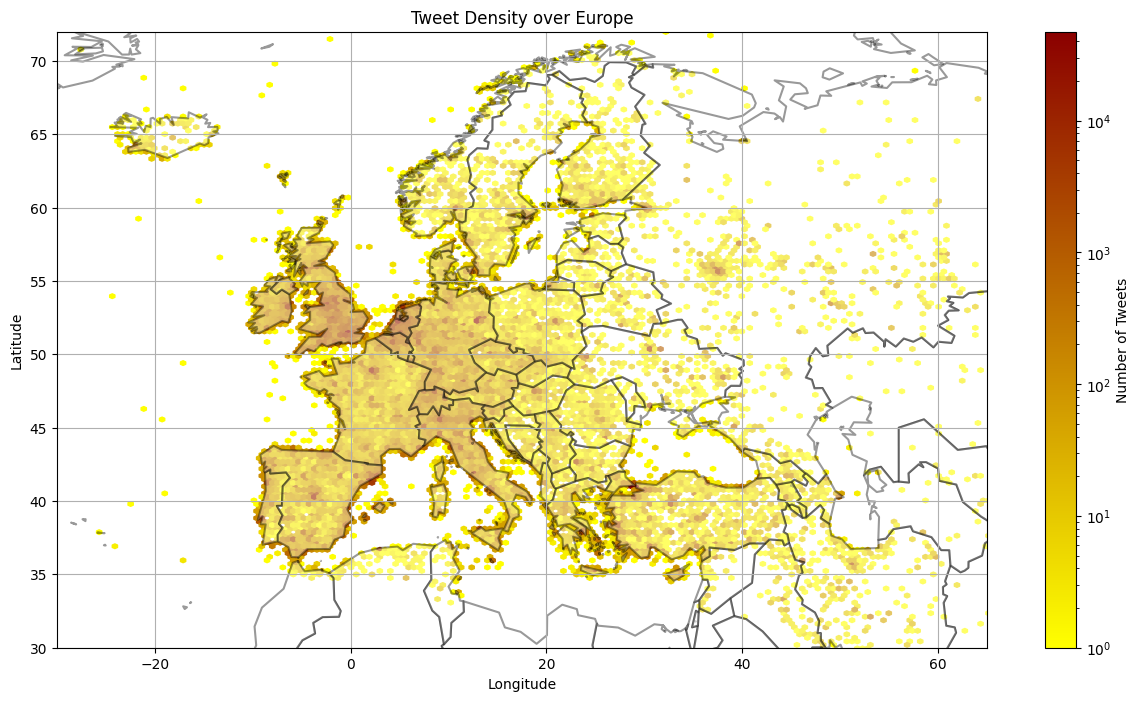

In [6]:
# Create custom colour map
cmap = LinearSegmentedColormap.from_list('custom blue', [(0,'#ffff00'),(1,'#8B0000')], N=256)

# Make subplot
fig , ax = plt.subplots(figsize = (15 ,8))

# Hexbin for tweets
ax1 = ax.hexbin(x_coord , y_coord , gridsize = 300 , bins = 'log' , cmap = cmap);
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

# Overlay map
p = PatchCollection(patches , edgecolor = 'k' , lw = 1.5 , facecolor = 'white' , alpha = 0.4);
ax.add_collection(p);

# Add collection to axes
ax.set_xlabel('Longitude');
ax.set_ylabel('Latitude');

# Plot Characteristics
plt.title('Tweet Density over Europe');
plt.xlim(-30 , 65);
plt.ylim(30 , 72);
plt.grid();
plt.show()

In [50]:
# mapping_df[
#     (mapping_df['long'] <= -20)&(mapping_df['long'] >= -30)&(mapping_df['lat'] <= 60)&(mapping_df['lat'] >= 40)
# ]

# mapping_df[
#     (mapping_df['long'] <= 50.)&(mapping_df['long'] >= 50)&(mapping_df['lat'] <= 41)&(mapping_df['lat'] >= 40)
# ]


### **QUESTION - 2**

**Patterns observed:**
1. We can make out the hotspots are centered around places of high population. The further north we go, the lesser tweets show up - indicating (most likely) a drop in population. As we see, the map is bright red over the capitals, especially
Dublin, Paris, Madrid, Berlin, Amsterdam, Copenhagen, Warsaw, Istanbul etc.
2. Large concentrations of tweets also come from big cities which aren't capitals - examples, Barcelona, Malaga
3. We notice that there is a lot more activity along the coastlines, but this is likely due to the presence of big port cities like Nice and Barcelona
4. Weird - Tweets from the middle of oceans and seas - Mediterranean Sea, Atlantic Ocean, Black Sea, Caspian Sea - why? Warrants further investigation.

|tweet_id|ca|coord|long|lat|Upon Investigation|
|------|---|----|----|----|---|
|1533337596746641408|Sun Jun 05 06:39:05 +0000 2022|[-21.27164652, 46.22221795]|-21.271647|46.222218|Bot|
|1533508726941941760|Sun Jun 05 17:59:06 +0000 2022|[-24.28624634, 53.9213375]|-24.286246|53.921337|Bot|
|1540622846317236224|Sat Jun 25 09:08:04 +0000 2022|[-21.77321261, 59.35389222]|-21.773213|59.353892|Bot|






### **QUESTION - 3**
The rest of the tweets should have a “place” tag. For these tweets, plot the CDF of the bounding box diagonals and comment.

In [7]:
%%time

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils

tweets = []
coord = []
bb1 = []
bb2 = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        tweets.append(line[0])
        coord.append(line[1])
        bb1.append(line[2])
        bb2.append(line[3])

In [ ]:
%%time

# Use tweets and coordinates to create a mapping dataframe
bounding_box_df = pd.DataFrame(
    list(zip(tweets , coord , bb1 , bb2)) , columns = ['tweet_id' , 'exact_coord' , 'bb1' , 'bb2']
)

bounding_box_df = bounding_box_df[bounding_box_df['tweet_id']!="None"]
bounding_box_df.drop_duplicates(inplace = True)

# Record length
len_1 = len(bounding_box_df)

# Length must be around 15 million
print(f'length after removal of null tweets = {len_1}')

# Remove rec w/o bounding box
bounding_box_df = bounding_box_df[(bounding_box_df['bb1']!="None")&(bounding_box_df['bb2']!="None")]

# Record length
len_2 = len(bounding_box_df)

print(f'length after removal of null bounding boxes = {len_2}, i.e. ~ {np.round((len_1-len_2)/len_1 , 4)*100}% did not have proper bounding boxes')

# Remove rec already with an exact coordinate
bounding_box_df = bounding_box_df[bounding_box_df['exact_coord']=="None"]

# Record length
len_3 = len(bounding_box_df)

print(f'length after removal of non-null exact coord = {len_3}, i.e. ~ {np.round((len_2 - len_3)/len_1 , 4)*100}% had exact coordinates')

length after removal of null tweets = 15033548
length after removal of null bounding boxes = 15026765, i.e. ~ 0.05% did not have proper bounding boxes
length after removal of non-null exact coord = 14331587, i.e. ~ 4.62% had exact coordinates
CPU times: total: 51.1 s
Wall time: 51.1 s


In [ ]:
%%time
bounding_box_df = to_coord(bounding_box_df , coord_cols=['bb1' , 'bb2']).drop('exact_coord' , axis = 1)

# Construct diagonals
bounding_box_df['diagonal'] = np.sqrt((bounding_box_df['bb1_long'] - bounding_box_df['bb2_long'])**2 + (bounding_box_df['bb1_lat'] - bounding_box_df['bb2_lat'])**2)

bounding_box_df.sort_values('diagonal' , ascending=False).head(20)

CPU times: total: 1min 19s
Wall time: 1min 19s


,tweet_id,bb1_long,bb1_lat,bb2_long,bb2_lat,diagonal
5751493,1535988175771926529,-73.263466,59.777268,-11.312319,83.627419,66.38354
11636758,1540262984500527105,-73.263466,59.777268,-11.312319,83.627419,66.38354
120868,1531918770360532994,-73.263466,59.777268,-11.312319,83.627419,66.38354
2773218,1533808291800723456,-73.263466,59.777268,-11.312319,83.627419,66.38354
5763873,1535995387638579201,-73.263466,59.777268,-11.312319,83.627419,66.38354
118356,1531917299556532226,-73.263466,59.777268,-11.312319,83.627419,66.38354
12967169,1541157956997316609,-73.263466,59.777268,-11.312319,83.627419,66.38354
13905388,1541858832548347906,-73.263466,59.777268,-11.312319,83.627419,66.38354
486451,1532106490747691014,-73.263466,59.777268,-11.312319,83.627419,66.38354
13008862,1541180509165854723,-73.263466,59.777268,-11.312319,83.627419,66.38354


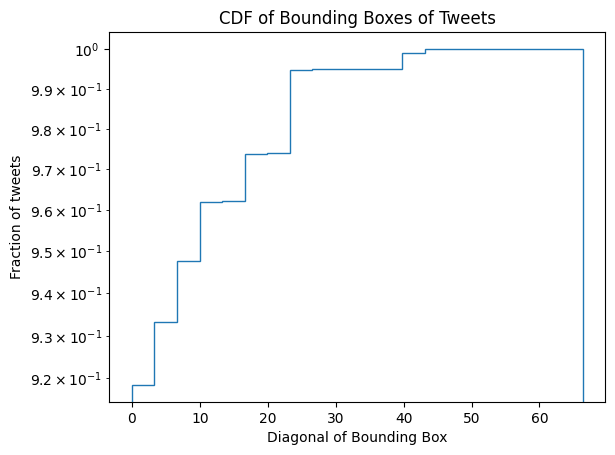

In [ ]:
diags = bounding_box_df['diagonal']

# Plot
fig , ax = plt.subplots()

ax.hist(diags , bins = 20 , density = True , cumulative = True , histtype = 'step');
ax.set_yscale('log');
ax.set_xlabel('Diagonal of Bounding Box');
ax.set_ylabel('Fraction of tweets');
plt.title('CDF of Bounding Boxes of Tweets');

### **Tweets with HUGE bounding boxes seem to be originating in Greenland & secondly, around Norway and Findland**

The reason **MAY** interesting - From a Euclidean geomterical perspective, it may seem odd that the bounding boxes are so big! But, remember, the closer you move to the poles, the longitudes bunch up together! Hence, they appear larger - it is the same reason why Greenland is disproportionately bigger on flat maps.

Or is the bounding box just really big?

Maybe there's something more interesting at play here - Notice all of the top 20 tweets (as per size of bounding box) have the exact same bounding box

### **QUESTION - 4**
Find one additional spatial dataset, produce a map comparing Twitter activity with the other dataset and discuss. Your secondary dataset doesn’t have to cover the entire bounding box e.g. it could be for a single city or nation.

In [ ]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
# user = []
ts = []
# ca = []
tweets = []
# mentions = []
coord = []
# country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        # user.append(line[0])
        ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        # mentions.append(line[4])
        coord.append(line[5])
        # country.append(line[6])

In [ ]:
%%time

# Make DF
twt_coord_df_0 = pd.DataFrame(
    list(zip( tweets , coord)) , 
    columns = ['tweet_id' , 'coord']
)

twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['tweet_id']!= "None"].drop_duplicates()
print(f'length is {len(twt_coord_df_0)}')
twt_coord_df_0 = twt_coord_df_0[twt_coord_df_0['coord']!= "None"].drop_duplicates()
print(f'length after removing blank coord is {len(twt_coord_df_0)}')

In [ ]:
# Restrict Coords
long_max = 0.3
long_min = -0.5
lat_max = 51.6
lat_min = 51.3
twt_coord_df = to_coord(twt_coord_df_0 , ['coord'])

# Constrict to an area over London
twt_coord_df = twt_coord_df[
    (twt_coord_df['coord_long']>=long_min)&(twt_coord_df['coord_long']<=long_max)&
    (twt_coord_df['coord_lat']>=lat_min)&(twt_coord_df['coord_lat']<=lat_max)
]
x_coord = twt_coord_df['coord_long']
y_coord = twt_coord_df['coord_lat']

In [ ]:
%%time

shape_file = os.path.join(os.getcwd() , 'Green spaces London\\Green spaces London\\Green_spaces.shp')

patches_greenery = []

with fiona.open(shape_file) as layers:
    for feature in layers:
        p = shape(feature['geometry'])
        try:
            # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
            lons , lats = np.array(p.exterior.coords.xy)
            lons_and_lats = list(zip(lons, lats))
            wgs84_coord = []
            for lon_and_lat in lons_and_lats:
                wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
            patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))
        except AttributeError:
            for poly in p.geoms:
                # idk..something weird is happening with the lats and longs - some sort of switch. swapped them for now
                lons , lats = np.array(poly.exterior.coords.xy)
                lons_and_lats = list(zip(lons, lats))
                wgs84_coord = []
                for lon_and_lat in lons_and_lats:
                    wgs84_coord.append(OSGB36toWGS84(lon_and_lat[0] , lon_and_lat[1])[::-1])
                patches_greenery.append(PolygonPatch(wgs84_coord , closed = False))

In [ ]:
%%time

shape_file = os.path.join(os.getcwd() , 'groads-v1-europe-shp\\groads-v1-europe-shp')

patches = []

with fiona.open(shape_file) as layers:
    for feature in layers:
        p = shape(feature['geometry'])
        try:
            lons , lats = np.array(p.xy)
            lons_and_lats = list(zip(lons, lats))
            patches.append(PolygonPatch(lons_and_lats , closed = False))
        except NotImplementedError:
            for poly in p.geoms:
                lons , lats = np.array(poly.xy)
                lons_and_lats = list(zip(lons, lats))
                patches.append(PolygonPatch(lons_and_lats , closed = False))

In [ ]:
# Make subplot
fig , ax = plt.subplots(figsize = (10,6))

p1 = PatchCollection(patches_greenery , edgecolor = 'green' , lw = 0.01 , facecolor = 'green', alpha  = 0.5);
ax.add_collection(p1);

p2 = PatchCollection(patches , edgecolor = 'k' , lw = 0.5 , facecolor = 'white', alpha =0.5);
ax.add_collection(p2);

# Scatter for tweets
# ax1 = ax.hexbin(x_coord , y_coord , gridsize = 200 , bins = 'log' , cmap = "Reds");
ax.scatter(x_coord, y_coord,s=0.2,c='red')
cbar = fig.colorbar(ax1);
cbar.set_label('Number of Tweets');

plt.xlabel('Longitude');
plt.ylabel('Latitude');
plt.autoscale();
plt.title('Greenery and Tweets in London')
plt.xlim(long_min,long_max);
plt.ylim(lat_min,lat_max);